## Explore the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import statsmodels.api as smg
import seaborn as sns

In [5]:
# Load pickled data
strat_splits = []
for i in range(10):
    split = []
    for j in range(2):
        split.append(pd.read_pickle(f'pickled-data/df_{i}-{j}.pkl'))
    strat_splits.append(split)
print("Confirm 10 stratified splits pickled. No of splits = ", len(strat_splits))

Confirm 10 stratified splits pickled. No of splits =  10


In [6]:
strat_train_set, strat_test_set = strat_splits[0]
strat_train_set.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,trip_duration
5629127,2,2020-01-29 13:36:22,2020-01-29 13:43:14,1.0,1.23,1.0,N,238,166,2,...,1.1,7.2,NaN,NaN,NaN,7.8,NaN,1018.2,NaN,0 days 00:06:52
3950490,2,2020-01-19 12:04:41,2020-01-19 12:08:42,2.0,1.01,1.0,N,141,263,1,...,0.6,7.2,NaN,NaN,NaN,10.2,NaN,1008.9,NaN,0 days 00:04:01
3215978,2,2020-01-16 00:18:38,2020-01-16 00:26:17,1.0,1.49,1.0,N,161,50,2,...,2.2,10.0,NaN,NaN,NaN,10.6,NaN,1015.1,NaN,0 days 00:07:39
2139620,1,2020-01-10 22:49:59,2020-01-10 23:08:07,1.0,4.80,1.0,N,230,74,1,...,1.1,11.7,NaN,NaN,265.0,14.5,NaN,1034.5,NaN,0 days 00:18:08
69250,2,2020-01-01 09:45:34,2020-01-01 09:58:58,6.0,1.16,1.0,N,164,90,2,...,1.7,5.0,NaN,NaN,NaN,17.3,NaN,1008.2,NaN,0 days 00:13:24


In [7]:
# use a copy to keep original data intact
trips = strat_train_set.copy()
trips.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee', 'date', 'tavg',
       'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun',
       'trip_duration'],
      dtype='object')

1. Total amount == charges of fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, airport_fee
2. store_and_fwd_flag attribute is a categorical variable
3. RatecodeID a non continous variable
4. passenger_count a continous variable
5. PULocationID, DOLocationID - define the start and end of a trip
6. tpep_pickup_datetime, tpep_dropoff_datetime - define duration of a trip

#### Looking at corrrelations

In [8]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5123836 entries, 5629127 to 4623401
Data columns (total 31 columns):
 #   Column                 Dtype          
---  ------                 -----          
 0   VendorID               int64          
 1   tpep_pickup_datetime   datetime64[us] 
 2   tpep_dropoff_datetime  datetime64[us] 
 3   passenger_count        float64        
 4   trip_distance          float64        
 5   RatecodeID             float64        
 6   store_and_fwd_flag     object         
 7   PULocationID           int64          
 8   DOLocationID           int64          
 9   payment_type           int64          
 10  fare_amount            float64        
 11  extra                  float64        
 12  mta_tax                float64        
 13  tip_amount             float64        
 14  tolls_amount           float64        
 15  improvement_surcharge  float64        
 16  total_amount           float64        
 17  congestion_surcharge   float64        
 18  a

In [ ]:
temp = trips # create a copy so not to break the original data
# fill missing values in airport_fee with zero
temp["airport_fee"] = temp["airport_fee"].fillna(value=0)
# add dummy values for categorical attribute store_and_fwd_flag
temp = pd.get_dummies(temp, prefix='store_and_fwd_flag', columns=['store_and_fwd_flag'])
# convert date to datetime64[us]
temp["date"] = temp["date"].astype("datetime64[us]")
# convert trip-duration to TimeDelta64[us] to minutes
temp["trip_duration"] = temp["trip_duration"]/pd.Timedelta(minutes=1)



In [47]:
corr_matrix = temp.corr()
# looking at how each attribute correlates with trip_duration
corr_matrix["trip_duration"].sort_values(ascending=False)

trip_duration            1.000000
fare_amount              0.141076
total_amount             0.136424
tolls_amount             0.071874
tip_amount               0.065219
VendorID                 0.033298
RatecodeID               0.018737
passenger_count          0.015711
trip_distance            0.006002
tpep_dropoff_datetime    0.005740
pres                     0.004559
improvement_surcharge    0.002509
date                     0.000794
tpep_pickup_datetime     0.000785
tmax                    -0.000111
tavg                    -0.000325
wspd                    -0.000748
tmin                    -0.000958
mta_tax                 -0.004290
store_and_fwd_flag_Y    -0.005362
payment_type            -0.006355
store_and_fwd_flag_N    -0.010036
PULocationID            -0.014135
congestion_surcharge    -0.017859
DOLocationID            -0.018737
extra                   -0.020988
airport_fee                   NaN
prcp                          NaN
snow                          NaN
wdir          

From the correlations the most promising attributes to predict the target variable "trip_duration" are "fare_amount", "total_amount", "tolls_amount", "tip_amount" though not strongly correlated

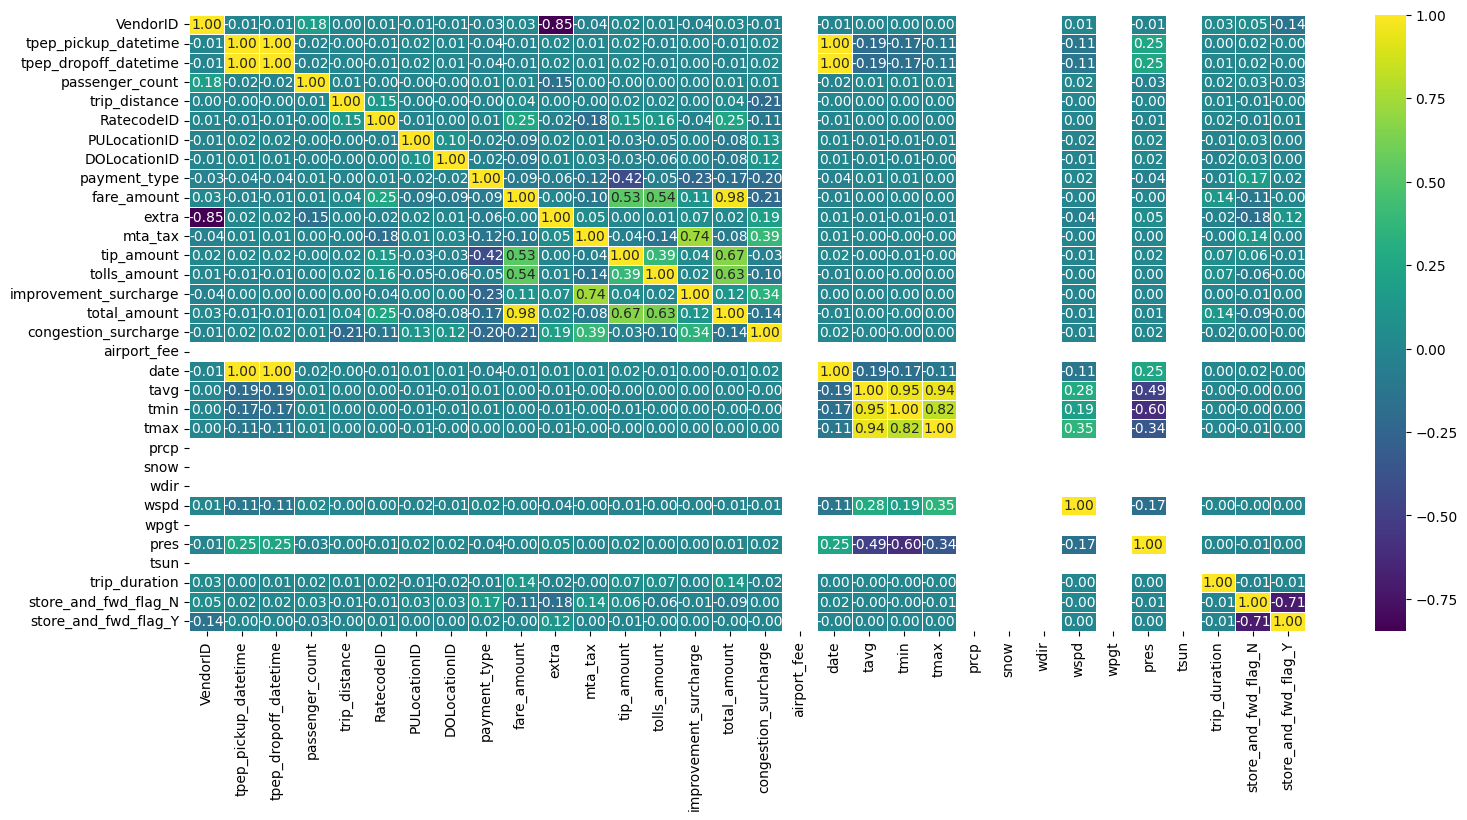

In [41]:
plt.figure(figsize=(18, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.show()

In [50]:
# Extract features from datetime columns
temp['pickup_weekday'] = temp['tpep_pickup_datetime'].dt.weekday
temp['pickup_month'] = temp['tpep_pickup_datetime'].dt.month
temp['pickup_hour'] = temp['tpep_pickup_datetime'].dt.hour
temp['pickup_minute'] = temp['tpep_pickup_datetime'].dt.minute

In [52]:
corr_matrix = temp.corr()
# looking at how each attribute correlates with trip_duration
corr_matrix["trip_duration"].sort_values(ascending=False)

trip_duration            1.000000
fare_amount              0.141076
total_amount             0.136424
tolls_amount             0.071874
tip_amount               0.065219
VendorID                 0.033298
RatecodeID               0.018737
passenger_count          0.015711
trip_distance            0.006002
tpep_dropoff_datetime    0.005740
pres                     0.004559
improvement_surcharge    0.002509
date                     0.000794
tpep_pickup_datetime     0.000785
tmax                    -0.000111
pickup_hour             -0.000189
tavg                    -0.000325
pickup_weekday          -0.000417
wspd                    -0.000748
tmin                    -0.000958
pickup_minute           -0.001921
mta_tax                 -0.004290
store_and_fwd_flag_Y    -0.005362
payment_type            -0.006355
store_and_fwd_flag_N    -0.010036
PULocationID            -0.014135
congestion_surcharge    -0.017859
DOLocationID            -0.018737
extra                   -0.020988
airport_fee   

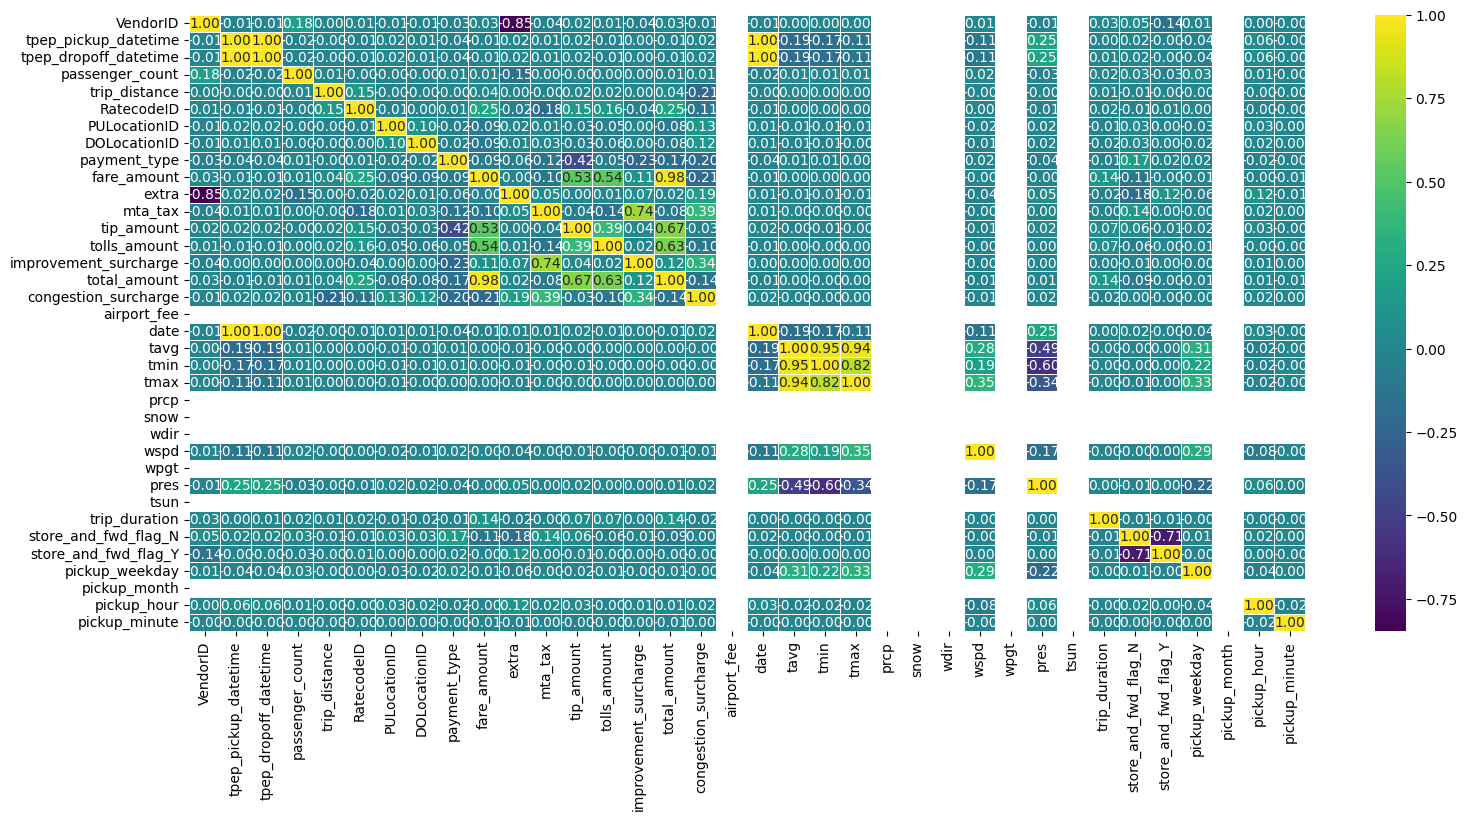

In [53]:
plt.figure(figsize=(18, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.show()

##### Scatter_matrix()
Pair plot to check correlation between the most promising attributes to predict trip duration value. "fare_amount", "total_amount", "tolls_amount", "tip_amount"

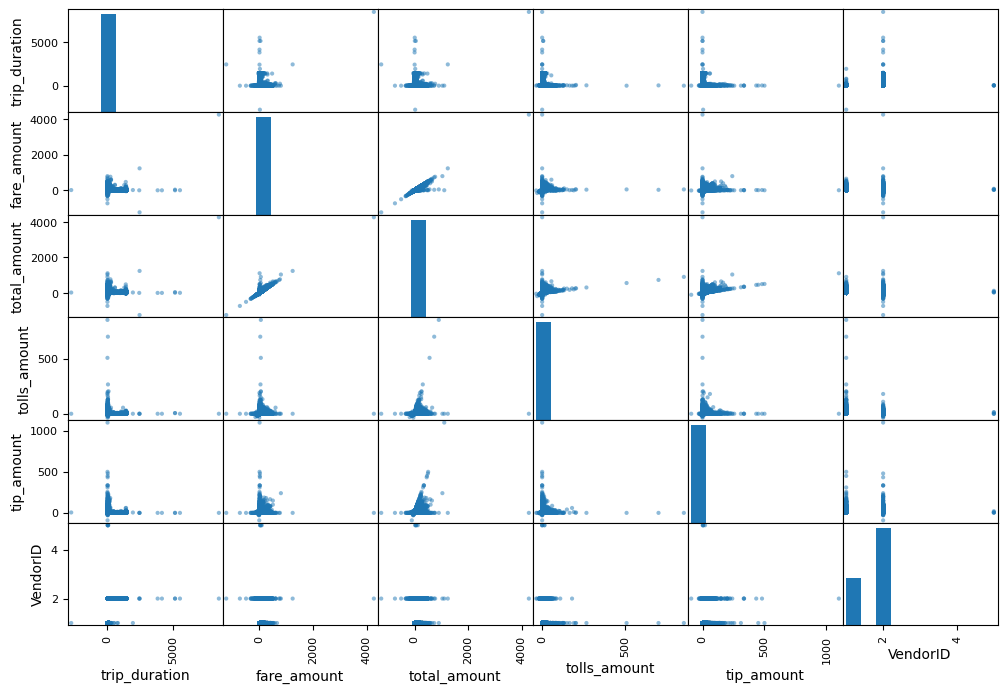

In [44]:
# using pandas scatter_matrix() to check correlation in the most promising attributes
from pandas.plotting import scatter_matrix

attributes = ["trip_duration", "fare_amount", "total_amount", "tolls_amount", "tip_amount", "VendorID"]
scatter_matrix(temp[attributes], figsize=(12, 8))
plt.show()

From the pair-plots above it is not obvious that there is a strong correlation between trip_duration and the rest of the promising attributes. Since we would expect a positive correlations to be indicated by a clustering of data points along a line from the bottom left to the top right of a scatter plot cell. However, the points showing the expected clustring for a positive correlation is fare amount and total amount which is obvious.